# Phase 1: Residential Building Consent Dataset

## INPUTS
1.	Geocoded individual consent data  
Various information (specified below under OUTPUTS) need to be added to each observation in these two datasets 
-	csv file containing building consents for 2000 to 2020 [filename: BCs_issued_by_AUP_TLADCs_2021FEB.csv]
2.	LINZ spine from phase 0

## OUTPUTS
csv file of building consents with the data fields 1-9 above. The matching process for assigning each consent to a LINZ parcel is described below. 
The following additional data fields are added. These are flags to designate the match to the LINZ dataset.

10.	Ranged Address Indicator  
a.	Indicator (1 or 0) for LINZ parcel that is part of a ranged address consent Ranged_Address_indicator

In [1]:
#pragma nodebook off
#Use nodebook for better reproducibility https://github.com/uoa-eResearch/nodebook
%reload_ext nodebook.ipython
%nodebook disk phase1

<IPython.core.display.Javascript object>

In [ ]:
# load libraries
import geopandas as gpd # vector data
import pandas as pd # tabular data, loading CSVs
import numpy as np # numeric data
from util import *
import matplotlib # plotting
import contextily as ctx # Used for contextual basemaps
from scipy.spatial import cKDTree
from matplotlib_scalebar.scalebar import ScaleBar # scalebar for plot
import matplotlib.pyplot as plt # plotting
from tqdm.auto import tqdm # progress bars
tqdm.pandas()
import json
from shapely.geometry import Point, shape, LineString, MultiLineString, GeometryCollection, MultiPoint, Polygon  # creating points
plt.rcParams['figure.figsize'] = (20, 20)
pd.set_option('max_columns', None)
pd.set_option('max_rows', 300)

In [ ]:
%%time
df = pd.read_csv("restricted/BCs_issued_by_AUP_TLADCs_2021FEB.csv", encoding='cp1252')
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_Coordinate, df.Y_Coordinate), crs=4326)

CPU times: user 1.52 s, sys: 382 ms, total: 1.9 s
Wall time: 1.92 s


In [ ]:
df

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry
0,227614,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",398 PAKIRI BLOCK ROAD,Tomarata,Auckland,Rodney,Houses,1111,231.0,NaN,1,Residential,Detached,NaN,NaN,2014,135900.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.634550,-36.224858,POINT (174.63455 -36.22486)
1,227656,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Ahuroa Road,Puhoi,Auckland,Rodney,Non-building construction,3111,0.0,NaN,1,Other,NaN,NaN,NaN,2014,146701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.568721,-36.475863,POINT (174.56872 -36.47586)
2,227796,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Upper Orewa Road,Upper Orewa,Auckland,Rodney,"Townhouses, flats, units, and other dwellings",1129,260.0,NaN,2,Residential,Attached,NaN,NaN,2014,177701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.641586,-36.590190,POINT (174.64159 -36.59019)
3,227896,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",56 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,179.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (174.54174 -36.77819)
4,227902,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",77 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,180.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (174.54174 -36.77819)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207221,151352,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",164-168,HOBSON ST,AUCKLAND,Waitemata,New Flats,1200,0.0,3650000.0,0,Residential,Attached,NaN,NaN,1998,434200.0,2013.0,Business - City Centre Zone,Business,35.0,CBD_1,Central Area A,Business,Commercial,NaN,NaN,174.760314,-36.851526,POINT (174.76031 -36.85153)
207222,151351,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",464,REMUERA RD,REMUERA,Orakei,New Flats,1200,0.0,120000.0,0,Residential,Attached,NaN,NaN,1998,490600.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,ACC_28,Residential 7c,Residential,NaN,NaN,NaN,174.801622,-36.880545,POINT (174.80162 -36.88055)
207223,151350,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",55B,PANORAMA RD,MOUNT WELLINGTON,Maungakiekie - Tamaki,"New (and pre-built) house, unit, bach, crib, b...",1100,140.0,200000.0,1,Residential,Detached,NaN,NaN,1998,643401.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,ACC_24,Residential 6a,Residential,NaN,NaN,NaN,174.830461,-36.904046,POINT (174.83046 -36.90405)
207224,151349,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",67,CUSTOMS ST EAST,AUCKLAND CENTRAL,Waitemata,New Offices,1461,0.0,0.0,1,Business,NaN,Group 2,Offices,1998,438104.0,2013.0,Business - City Centre Zone,Business,35.0,CBD_2,Central Area B,Business,Commercial,NaN,NaN,174.768483,-36.845564,POINT (174.76848 -36.84556)


In [ ]:
df["Ranged_Address_indicator"] = df.ADDRESS_1.str.contains('\d\w?\s?-', regex=True, na=False)
df["Ranged_Address_indicator"].value_counts()

False    200848
True       6378
Name: Ranged_Address_indicator, dtype: int64

11.	Matching Type Indicators:  
a.	LINZ_MATCH_CODE  
b.	LINZ_2ND_MATCH_CODE  
PROCEDURE FOR MATCHING CONSENTS TO LINZ PARCELS  
MATCHING FOR NON-RANGED ADDRESSES:  
   Find the LINZ parcel of the geo-coordinate of the consent.  
a. Check whether the address of the consent and the address of the LINZ parcel match, by matching on number and first word. If so, stop and set LINZ_MATCH_CODE = 1. If not, go on to 2:

In [ ]:
%%time
# get number and name of street (but not 'road', 'street', 'place' etc)
# this can be used to match addresses with building consents

def number_name_bc(x):
    """extract street number and first complete word of the street name from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3]]).lower()
        return ' '.join(joined_address.split(' ')[:2])

def full_address_bc(x):
    """extract full address from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3] if not str(x[f'ADDRESS_{i}']) == 'nan']).lower()
        return joined_address

df['number_name'] = df.apply(number_name_bc, axis=1)
df['full_address'] = df.apply(full_address_bc, axis=1)

CPU times: user 17.9 s, sys: 414 ms, total: 18.3 s
Wall time: 18.3 s


In [ ]:
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb').to_crs(2193)
parcels = parcels.set_index("id")
parcels

,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,geometry
id,,,,,,,,,,
4918991,Lot 327 DP 56341,DP 56341,DCDB,Primary,None,North Auckland,NA8C/911,642.0,643.0,"MULTIPOLYGON (((1764256.381 5917306.269, 17642..."
4919914,Lot 178 DP 56342,DP 56342,DCDB,Primary,None,North Auckland,"474924, NA8C/768",650.0,651.0,"MULTIPOLYGON (((1764569.269 5917546.907, 17645..."
4926734,Lot 144 DP 53562,DP 53562,DCDB,Primary,None,North Auckland,"386353, 386354, 386355, 386356, NA4D/859",640.0,640.0,"MULTIPOLYGON (((1764447.122 5917598.067, 17644..."
4926945,Lot 183 DP 56342,DP 56342,DCDB,Primary,None,North Auckland,"433646, NA8C/773",913.0,914.0,"MULTIPOLYGON (((1764510.216 5917605.992, 17644..."
4929034,Lot 260 DP 56341,DP 56341,DCDB,Primary,None,North Auckland,"488577, NA8C/850",622.0,624.0,"MULTIPOLYGON (((1764653.473 5917395.879, 17646..."
...,...,...,...,...,...,...,...,...,...,...
5227472,None,None,Road,Primary,None,North Auckland,None,NaN,1330.0,"MULTIPOLYGON (((1766929.317 5907928.650, 17669..."
5242816,None,None,Road,Primary,None,North Auckland,None,NaN,1049.0,"MULTIPOLYGON (((1766662.352 5908073.993, 17666..."
7520053,Lot 5 DP 465319,DP 465319,Fee Simple Title,Primary,None,North Auckland,621250,2253.0,2252.0,"MULTIPOLYGON (((1766988.975 5907984.681, 17669..."


In [ ]:
addresses = gpd.read_file('input/lds-nz-street-address-FGDB.zip!nz-street-address.gdb').to_crs(2193)
addresses

,address_id,change_id,address_type,unit_value,address_number,address_number_suffix,address_number_high,water_route_name,water_name,suburb_locality,town_city,full_address_number,full_road_name,full_address,road_section_id,gd2000_xcoord,gd2000_ycoord,water_route_name_ascii,water_name_ascii,suburb_locality_ascii,town_city_ascii,full_road_name_ascii,full_address_ascii,geometry
0,1492914,1299977,Road,None,117,None,NaN,None,None,Wade Heads,Whangaparaoa,117,Scott Road,"117 Scott Road, Wade Heads, Whangaparaoa",337316,174.730083,-36.636987,None,None,Wade Heads,Whangaparaoa,Scott Road,"117 Scott Road, Wade Heads, Whangaparaoa",POINT (1754671.502 5944002.869)
1,522015,464084,Road,None,1,None,NaN,None,None,Stanmore Bay,Whangaparaoa,1,Myra G Place,"1 Myra G Place, Stanmore Bay, Whangaparaoa",326879,174.737338,-36.638140,None,None,Stanmore Bay,Whangaparaoa,Myra G Place,"1 Myra G Place, Stanmore Bay, Whangaparaoa",POINT (1755317.873 5943863.257)
2,522017,464086,Road,None,5,None,NaN,None,None,Stanmore Bay,Whangaparaoa,5,Myra G Place,"5 Myra G Place, Stanmore Bay, Whangaparaoa",326879,174.736824,-36.637254,None,None,Stanmore Bay,Whangaparaoa,Myra G Place,"5 Myra G Place, Stanmore Bay, Whangaparaoa",POINT (1755273.657 5943962.319)
3,1729674,1459883,Road,None,121,None,NaN,None,None,Stanmore Bay,Whangaparaoa,121,Wade River Road,"121 Wade River Road, Stanmore Bay, Whangaparaoa",372844,174.734722,-36.638060,None,None,Stanmore Bay,Whangaparaoa,Wade River Road,"121 Wade River Road, Stanmore Bay, Whangaparaoa",POINT (1755084.134 5943876.304)
4,522016,464085,Road,None,3,None,NaN,None,None,Stanmore Bay,Whangaparaoa,3,Myra G Place,"3 Myra G Place, Stanmore Bay, Whangaparaoa",326879,174.737166,-36.637450,None,None,Stanmore Bay,Whangaparaoa,Myra G Place,"3 Myra G Place, Stanmore Bay, Whangaparaoa",POINT (1755303.833 5943940.045)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598473,1198349,1056644,Road,None,39,None,NaN,None,None,Glen Innes,Auckland,39,Mayfair Place,"39 Mayfair Place, Glen Innes, Auckland",182515,174.855726,-36.878217,None,None,Glen Innes,Auckland,Mayfair Place,"39 Mayfair Place, Glen Innes, Auckland",POINT (1765386.328 5917029.673)
598474,1198373,1056663,Road,None,41,None,NaN,None,None,Glen Innes,Auckland,41,Mayfair Place,"41 Mayfair Place, Glen Innes, Auckland",182515,174.855743,-36.878160,None,None,Glen Innes,Auckland,Mayfair Place,"41 Mayfair Place, Glen Innes, Auckland",POINT (1765387.988 5917035.899)
598475,2051395,2419664,Road,6,208,None,NaN,None,None,Glen Innes,Auckland,6/208,Taniwha Street,"6/208 Taniwha Street, Glen Innes, Auckland",185887,174.857392,-36.878158,None,None,Glen Innes,Auckland,Taniwha Street,"6/208 Taniwha Street, Glen Innes, Auckland",POINT (1765534.921 5917033.303)
598476,2070116,2482734,Road,12,208,None,NaN,None,None,Glen Innes,Auckland,12/208,Taniwha Street,"12/208 Taniwha Street, Glen Innes, Auckland",185887,174.857687,-36.878203,None,None,Glen Innes,Auckland,Taniwha Street,"12/208 Taniwha Street, Glen Innes, Auckland",POINT (1765561.100 5917027.855)


In [ ]:
def number_name_addresses(x):
    return ' '.join(x.split(' ')[:2]).lower()
addresses['address_number_name'] = addresses.full_address.apply(number_name_addresses)
addresses

,address_id,change_id,address_type,unit_value,address_number,address_number_suffix,address_number_high,water_route_name,water_name,suburb_locality,town_city,full_address_number,full_road_name,full_address,road_section_id,gd2000_xcoord,gd2000_ycoord,water_route_name_ascii,water_name_ascii,suburb_locality_ascii,town_city_ascii,full_road_name_ascii,full_address_ascii,geometry,address_number_name
0,1492914,1299977,Road,None,117,None,NaN,None,None,Wade Heads,Whangaparaoa,117,Scott Road,"117 Scott Road, Wade Heads, Whangaparaoa",337316,174.730083,-36.636987,None,None,Wade Heads,Whangaparaoa,Scott Road,"117 Scott Road, Wade Heads, Whangaparaoa",POINT (1754671.502 5944002.869),117 scott
1,522015,464084,Road,None,1,None,NaN,None,None,Stanmore Bay,Whangaparaoa,1,Myra G Place,"1 Myra G Place, Stanmore Bay, Whangaparaoa",326879,174.737338,-36.638140,None,None,Stanmore Bay,Whangaparaoa,Myra G Place,"1 Myra G Place, Stanmore Bay, Whangaparaoa",POINT (1755317.873 5943863.257),1 myra
2,522017,464086,Road,None,5,None,NaN,None,None,Stanmore Bay,Whangaparaoa,5,Myra G Place,"5 Myra G Place, Stanmore Bay, Whangaparaoa",326879,174.736824,-36.637254,None,None,Stanmore Bay,Whangaparaoa,Myra G Place,"5 Myra G Place, Stanmore Bay, Whangaparaoa",POINT (1755273.657 5943962.319),5 myra
3,1729674,1459883,Road,None,121,None,NaN,None,None,Stanmore Bay,Whangaparaoa,121,Wade River Road,"121 Wade River Road, Stanmore Bay, Whangaparaoa",372844,174.734722,-36.638060,None,None,Stanmore Bay,Whangaparaoa,Wade River Road,"121 Wade River Road, Stanmore Bay, Whangaparaoa",POINT (1755084.134 5943876.304),121 wade
4,522016,464085,Road,None,3,None,NaN,None,None,Stanmore Bay,Whangaparaoa,3,Myra G Place,"3 Myra G Place, Stanmore Bay, Whangaparaoa",326879,174.737166,-36.637450,None,None,Stanmore Bay,Whangaparaoa,Myra G Place,"3 Myra G Place, Stanmore Bay, Whangaparaoa",POINT (1755303.833 5943940.045),3 myra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598473,1198349,1056644,Road,None,39,None,NaN,None,None,Glen Innes,Auckland,39,Mayfair Place,"39 Mayfair Place, Glen Innes, Auckland",182515,174.855726,-36.878217,None,None,Glen Innes,Auckland,Mayfair Place,"39 Mayfair Place, Glen Innes, Auckland",POINT (1765386.328 5917029.673),39 mayfair
598474,1198373,1056663,Road,None,41,None,NaN,None,None,Glen Innes,Auckland,41,Mayfair Place,"41 Mayfair Place, Glen Innes, Auckland",182515,174.855743,-36.878160,None,None,Glen Innes,Auckland,Mayfair Place,"41 Mayfair Place, Glen Innes, Auckland",POINT (1765387.988 5917035.899),41 mayfair
598475,2051395,2419664,Road,6,208,None,NaN,None,None,Glen Innes,Auckland,6/208,Taniwha Street,"6/208 Taniwha Street, Glen Innes, Auckland",185887,174.857392,-36.878158,None,None,Glen Innes,Auckland,Taniwha Street,"6/208 Taniwha Street, Glen Innes, Auckland",POINT (1765534.921 5917033.303),6/208 taniwha
598476,2070116,2482734,Road,12,208,None,NaN,None,None,Glen Innes,Auckland,12/208,Taniwha Street,"12/208 Taniwha Street, Glen Innes, Auckland",185887,174.857687,-36.878203,None,None,Glen Innes,Auckland,Taniwha Street,"12/208 Taniwha Street, Glen Innes, Auckland",POINT (1765561.100 5917027.855),12/208 taniwha


In [ ]:
%%time
parcels_addressed = gpd.sjoin(parcels, addresses)

CPU times: user 38.5 s, sys: 2.94 s, total: 41.4 s
Wall time: 41.8 s


In [ ]:
%%time
parcel_address_number_name = parcels_addressed.groupby('id')['address_number_name'].apply(list)
parcel_address_number_name

CPU times: user 13.7 s, sys: 1.04 s, total: 14.8 s
Wall time: 15 s


id
575533           [8 aorere]
576109            [230 old]
579434         [68 opaheke]
579435         [2 boundary]
579774          [8 donovan]
                 ...       
8246915    [123a edgewater]
8247120          [1 loloma]
8247126          [3 loloma]
8247137      [73a mountain]
8247573        [18 addison]
Name: address_number_name, Length: 441888, dtype: object

In [ ]:
parcels["addresses"] = parcel_address_number_name

In [ ]:
%%time
df = gpd.sjoin(df.to_crs(2193), parcels[["addresses","geometry"]], how="left")

CPU times: user 27.7 s, sys: 1.2 s, total: 28.9 s
Wall time: 29.1 s


In [ ]:
print(sum(df.number_name.str.contains("mt")),
sum(df.number_name.str.contains("mount")),
sum(addresses.address_number_name.str.contains("mt")),
sum(addresses.address_number_name.str.contains("mount")))

690 597 132 4849


In [ ]:
df = df.rename(columns={"index_right": "LINZ_parcel_ID"})
df.LINZ_parcel_ID = df.LINZ_parcel_ID.astype("Int64")
df

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses
0,227614,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",398 PAKIRI BLOCK ROAD,Tomarata,Auckland,Rodney,Houses,1111,231.0,NaN,1,Residential,Detached,NaN,NaN,2014,135900.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.634550,-36.224858,POINT (1746904.853 5989872.553),False,398 pakiri,398 pakiri block road tomarata auckland,5209817,NaN
1,227656,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Ahuroa Road,Puhoi,Auckland,Rodney,Non-building construction,3111,0.0,NaN,1,Other,NaN,NaN,NaN,2014,146701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.568721,-36.475863,POINT (1740536.028 5962125.407),False,ahuroa road,ahuroa road puhoi auckland,5227114,NaN
2,227796,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Upper Orewa Road,Upper Orewa,Auckland,Rodney,"Townhouses, flats, units, and other dwellings",1129,260.0,NaN,2,Residential,Attached,NaN,NaN,2014,177701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.641586,-36.590190,POINT (1746847.868 5949333.496),False,upper orewa,upper orewa road upper orewa auckland,6605265,NaN
3,227896,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",56 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,179.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (1737579.970 5928624.665),False,56 vinistra,56 vinistra road huapai auckland,7859219,NaN
4,227902,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",77 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,180.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (1737579.970 5928624.665),False,77 vinistra,77 vinistra road huapai auckland,7859219,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207221,151352,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",164-168,HOBSON ST,AUCKLAND,Waitemata,New Flats,1200,0.0,3650000.0,0,Residential,Attached,NaN,NaN,1998,434200.0,2013.0,Business - City Centre Zone,Business,35.0,CBD_1,Central Area A,Business,Commercial,NaN,NaN,174.760314,-36.851526,POINT (1756936.812 5920152.000),True,164-168 hobson,164-168 hobson st auckland,6752833,"[37 cook, 1305/168 hobson, 1304/168 hobson, 12..."
207222,151351,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",464,REMUERA RD,REMUERA,Orakei,New Flats,1200,0.0,120000.0,0,Residential,Attached,NaN,NaN,1998,490600.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,ACC_28,Residential 7c,Residential,NaN,NaN,NaN,174.801622,-36.880545,POINT (1760559.126 5916863.750),False,464 remuera,464 remuera rd remuera,4928237,"[2/464 remuera, 1/464 remuera, 3b/464 remuera,..."
207223,151350,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",55B,PANORAMA RD,MOUNT WELLINGTON,Maungakiekie - Tamaki,"New (and pre-built) house, unit, bach, crib, b...",1100,140.0,200000.0,1,Residential,Detached,NaN,NaN,1998,643401.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,ACC_24,Residential 6a,Residential,NaN,NaN,NaN,174.830461,-36.904046,POINT (1763079.439 5914207.500),False,55b panorama,55b panorama rd mount wellington,4963967,[55 panorama]
207224,151349,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",67,CUSTOMS ST EAST,AUCKLAND CENTRAL,Waitemata,New Offices,1461,0.0,0.0,1,Business,NaN,Group 2,Offices,1998,438104.0,2013.0,Business - City Centre Zone,Business,35

In [ ]:
assert df.index.is_unique

In [ ]:
def check_match(row):
    if row.number_name in row.addresses:
        return 1
    return np.nan
match = df[~pd.isna(df.number_name) & ~pd.isna(df.addresses)].apply(check_match, axis=1)
df["LINZ_MATCH_CODE"] = match
df.LINZ_MATCH_CODE.value_counts(dropna=False)

1.0    124049
NaN     83177
Name: LINZ_MATCH_CODE, dtype: int64

Find all the LINZ parcels within r radius of the geo-coordinate of the consent  
a.       Search for a match of the consent address within the set of LINZ parcels within the radius r. If a match is found, stop and set LINZ_MATCH_CODE = 2. If there is no match, go on to 3:

In [ ]:
parcel_tree = cKDTree(list(parcels.centroid.apply(lambda x: (x.x, x.y))))
parcel_tree

In [ ]:
sample = df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(addresses.address_number_name)].head(1)
sample

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses,LINZ_MATCH_CODE
3,227896,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",56 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,179.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (1737579.970 5928624.665),False,56 vinistra,56 vinistra road huapai auckland,7859219,NaN,NaN


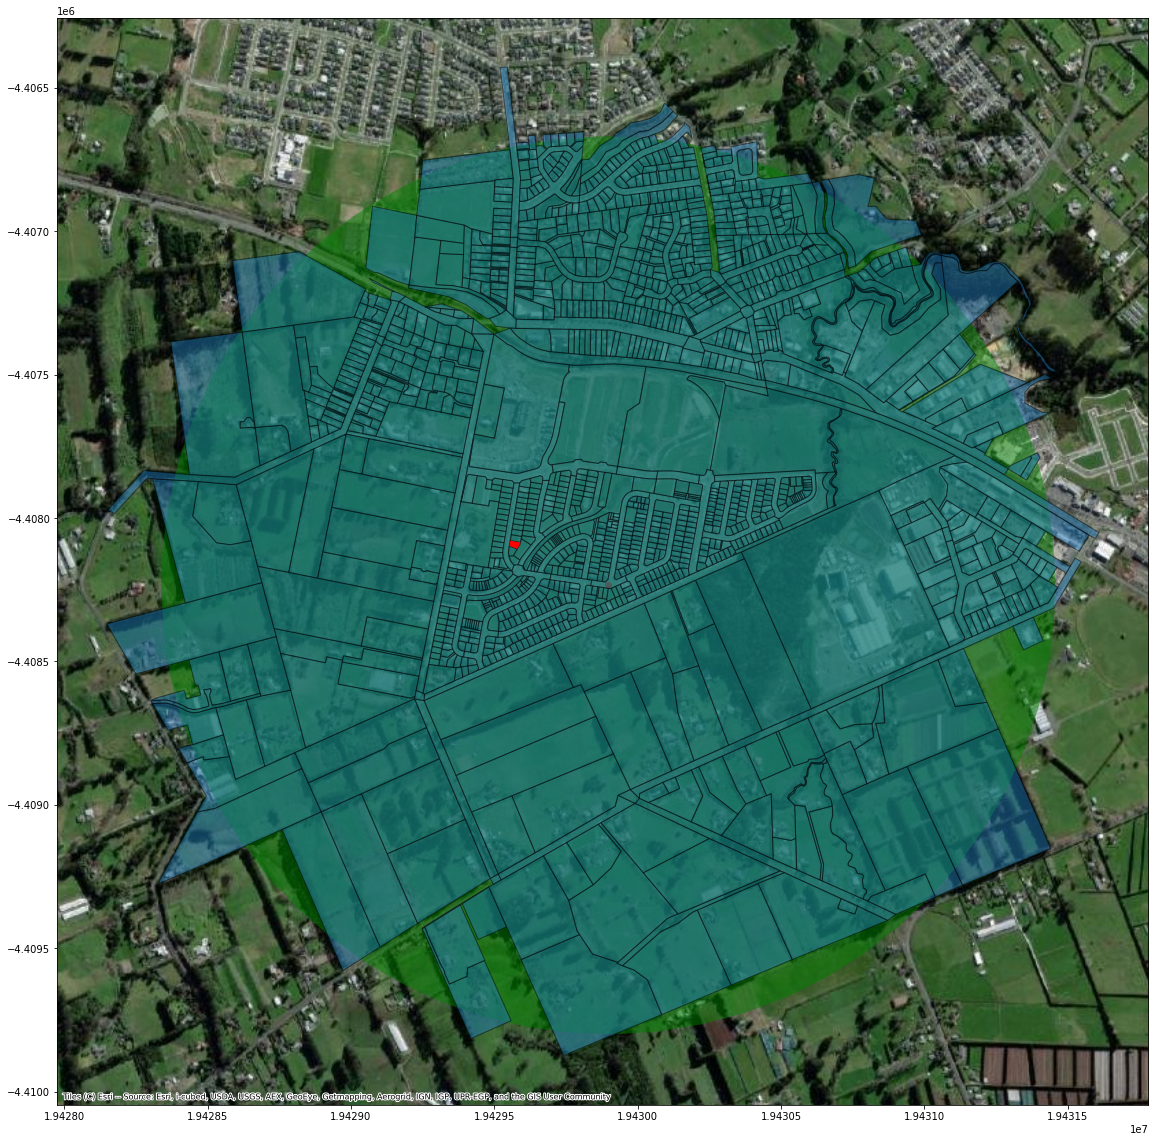

In [ ]:
indices_in_range = parcel_tree.query_ball_point([sample.centroid.iloc[0].x, sample.centroid.iloc[0].y], 1250)
ax = sample.to_crs(epsg=3857).plot(color="red", alpha=1)
sample.buffer(1250).to_crs(epsg=3857).plot(ax=ax, alpha=.5, color="green")
potential_matches = parcels.iloc[indices_in_range]
potential_matches.to_crs(epsg=3857).plot(ax=ax, alpha=.5, edgecolor="black")
potential_matches[potential_matches.addresses.str.contains(sample.number_name.iloc[0], na=False, regex=False)].to_crs(epsg=3857).plot(ax=ax, color="red")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

In [ ]:
def find_match_in_range(row):
    indices_in_range = parcel_tree.query_ball_point([row.geometry.x, row.geometry.y], 1250)
    potential_matches = parcels.iloc[indices_in_range]
    match = potential_matches[potential_matches.addresses.str.contains(row.number_name, na=False, regex=False)]
    if len(match):
        row.LINZ_parcel_ID = match.index[0]
        row.addresses = match.addresses.iloc[0]
        row.LINZ_MATCH_CODE = 2
    return row
matches = df[
    ~pd.isna(df.number_name) &
    pd.isna(df["LINZ_MATCH_CODE"]) &
    df.number_name.isin(addresses.address_number_name)].progress_apply(find_match_in_range, axis=1)

  0%|          | 0/40667 [00:00<?, ?it/s]

In [ ]:
matches

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses,LINZ_MATCH_CODE
3,227896,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",56 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,179.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (1737579.970 5928624.665),False,56 vinistra,56 vinistra road huapai auckland,8081617,[56 vinistra],2.0
4,227902,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",77 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,180.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (1737579.970 5928624.665),False,77 vinistra,77 vinistra road huapai auckland,8081611,[77 vinistra],2.0
6,227911,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",753A COATESVILLE-RIVERHEAD HIGHWAY,Riverhead,Auckland,Rodney,Non-building construction,3111,0.0,NaN,1,Other,NaN,NaN,NaN,2014,214502.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.584367,-36.783907,POINT (1741373.805 5927928.444),False,753a coatesville-riverhead,753a coatesville-riverhead highway riverhead a...,5230689,NaN,NaN
7,227912,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",21 DIAMOND LANE,Riverhead,Auckland,Rodney,Farm buildings,2711,313.0,NaN,1,Other,NaN,NaN,NaN,2014,216902.0,2013.0,Road,General,27.0,RDC_2,Countryside Living Rural,Rural,NaN,NaN,NaN,174.618681,-36.761155,POINT (1744478.626 5930401.325),False,21 diamond,21 diamond lane riverhead auckland,7741687,[21 diamond],2.0
9,227954,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",60 CLARK ROAD,Hobsonville,Auckland,Upper Harbour,Houses,1111,195.0,NaN,1,Residential,Detached,NaN,NaN,2014,222600.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_16,Special Area,Special,NaN,"Scott Point, Sunderland Precinct, Hobsonville ...","Scott Point, Sunderland Precinct, Hobsonville ...",174.652342,-36.798024,POINT (1747412.651 5926259.663),False,60 clark,60 clark road hobsonville auckland,8185386,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207198,151375,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",20A,HOLBROOK ST,AVONDALE,Whau,"New (and pre-built) house, unit, bach, crib, b...",1100,241.0,350000.0,1,Residential,Detached,NaN,NaN,1998,378602.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,ACC_18,Residential 5,Residential,NaN,NaN,NaN,174.704383,-36.908561,POINT (1751836.997 5913914.750),False,20a holbrook,20a holbrook st avondale,5086422,"[20a holbrook, 20b holbrook]",2.0
207203,151370,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",5B,COMMODORE DR,LYNFIELD,Puketapapa,"New (and pre-built) house, unit, bach, crib, b...",1100,160.0,250000.0,1,Residential,Detached,NaN,NaN,1998,587400.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,ACC_24,Residential 6a,Residential,NaN,NaN,NaN,174.720223,-36.926547,POINT (1753212.269 5911893.874),False,5b commodore,5b commodore dr lynfield,6810857,[5b commodore],2.0
207205,151368,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",54,ELLIS AVE,MOUNT ROSKILL,Puketapapa,"New (and pre-built) house, unit, bach, crib, b...",1100,158.0,268000.0,1,Residential,Detached,NaN,NaN,1998,584402.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,ACC_24,Residential 6a,Residential,NaN,NaN,NaN,174.719375,-36.912989,POINT (1753163.815 5913399.499),False,54 ellis,54 ellis ave m

In [ ]:
df.update(matches)
df.LINZ_MATCH_CODE.value_counts(dropna=False)

1.0    124049
NaN     48840
2.0     34337
Name: LINZ_MATCH_CODE, dtype: int64

In [ ]:
df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(addresses.address_number_name)]

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses,LINZ_MATCH_CODE
6,227911.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",753A COATESVILLE-RIVERHEAD HIGHWAY,Riverhead,Auckland,Rodney,Non-building construction,3111.0,0.0,NaN,1.0,Other,NaN,NaN,NaN,2014.0,214502.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.584367,-36.783907,POINT (1741373.805 5927928.444),False,753a coatesville-riverhead,753a coatesville-riverhead highway riverhead a...,5230689,NaN,NaN
9,227954.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",60 CLARK ROAD,Hobsonville,Auckland,Upper Harbour,Houses,1111.0,195.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,222600.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_16,Special Area,Special,NaN,"Scott Point, Sunderland Precinct, Hobsonville ...","Scott Point, Sunderland Precinct, Hobsonville ...",174.652342,-36.798024,POINT (1747412.651 5926259.663),False,60 clark,60 clark road hobsonville auckland,8185386,NaN,NaN
18,228723.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",344 FLAT BUSH SCHOOL ROAD,FLAT BUSH,Auckland,Howick,Non-building construction,3111.0,0.0,NaN,1.0,Other,NaN,NaN,NaN,2014.0,713100.0,2013.0,Road,General,27.0,MCC_ROAD,Secondary Road,Other,NaN,NaN,NaN,174.915055,-36.973715,POINT (1770461.566 5906329.777),False,344 flat,344 flat bush school road flat bush auckland,5209063,NaN,NaN
21,228822.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",149 GROVE ROAD,PAPAKURA,Auckland,Devonport - Takapuna,Houses,1111.0,100.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,332800.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.804500,-36.819603,POINT (1760943.384 5923620.191),False,149 grove,149 grove road papakura auckland,5222980,NaN,NaN
22,228824.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",173 GROVE ROAD,PAPAKURA,Auckland,Devonport - Takapuna,Houses,1111.0,100.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,332800.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.804500,-36.819603,POINT (1760943.384 5923620.191),False,173 grove,173 grove road papakura auckland,5222980,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207144,151429.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",62,BIRDWOOD AVE,PAPATOETOE,Otara - Papatoetoe,"New (and pre-built) house, unit, bach, crib, b...",1100.0,95.0,295000.0,1.0,Residential,Detached,NaN,NaN,1998.0,665300.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,MCC_MR,Main Residential,Residential,NaN,NaN,NaN,174.866824,-36.977261,POINT (1766160.311 5906021.614),False,62 birdwood,62 birdwood ave papatoetoe,7594476,[7 tukutuku],NaN
207145,151428.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",62,BIRDWOOD AVE,PAPATOETOE,Otara - Papatoetoe,"New (and pre-built) house, unit, bach, crib, b...",1100.0,120.0,295000.0,1.0,Residential,Detached,NaN,NaN,1998.0,665300.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,MCC_MR,Main Residential,Residential,NaN,NaN,NaN,174.866824,-36.977261,POINT (1766160.311 5906021.614),False,62 birdwood,62 birdwood ave papatoetoe,7594476,[7 tukutuku],NaN
207146,151427.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",62,BIRDWOOD AVE,PAPATOETOE,Otara - Papatoetoe,"New (and pre-built) house, unit, bach, crib, b...",1100.0,81.0,295000.0,1.0,Residential,Detached,NaN,NaN,1998.0,665300.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,MCC_MR,Main Residential,Residential,NaN,NaN,NaN,174.866824,-36.977261,POINT (1766160.311 5906021.61

In [ ]:
%%time
def find_text_match(row):
    match = parcels[parcels.addresses.str.contains(row.number_name, na=False, regex=False)]
    if len(match):
        closest_parcel_id = match.distance(row.geometry).idxmin()
        row.LINZ_parcel_ID = closest_parcel_id
        row.addresses = match.addresses[closest_parcel_id]
        row.LINZ_MATCH_CODE = 3
    return row
matches = df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(addresses.address_number_name)].progress_apply(find_text_match, axis=1)
df.update(matches)
df.LINZ_MATCH_CODE.value_counts(dropna=False)

  0%|          | 0/6330 [00:00<?, ?it/s]

CPU times: user 11min 11s, sys: 3.96 s, total: 11min 15s
Wall time: 11min 12s


1.0    124049
NaN     42510
2.0     34337
3.0      6330
Name: LINZ_MATCH_CODE, dtype: int64

In [ ]:
%%time
distances = df[~pd.isna(df.LINZ_parcel_ID)].distance(parcels.loc[df.LINZ_parcel_ID[~pd.isna(df.LINZ_parcel_ID)]], align=False)
distances

CPU times: user 9.66 s, sys: 541 ms, total: 10.2 s
Wall time: 10.2 s


0           0.000000
1           0.000000
2           0.000000
3         272.107738
4         302.608731
             ...    
207221      0.000000
207222      0.000000
207223     34.221509
207224      0.000000
207225      0.000000
Length: 207053, dtype: float64

In [ ]:
distances[distances>0].describe()

count     40667.000000
mean       2674.287749
std        8338.535776
min           0.000062
25%           9.526412
50%          29.306844
75%         230.652134
max      100594.158959
dtype: float64

In [ ]:
df["distance_to_parcel"] = distances

  Identify the LINZ parcel of the geo-coordinate of the consent. This will be the LINZ parcel used. Set LINZ_MATCH_CODE = 4. If there is no parcel under the geo-coordinate, go to step 5:

In [ ]:
df.LINZ_MATCH_CODE[~pd.isna(df.LINZ_parcel_ID) & pd.isna(df.LINZ_MATCH_CODE)] = 4

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df.LINZ_MATCH_CODE[pd.isna(df.LINZ_MATCH_CODE)] = 5
df.LINZ_MATCH_CODE.value_counts()

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.0    124049
4.0     42337
2.0     34337
3.0      6330
5.0       173
Name: LINZ_MATCH_CODE, dtype: int64

In [ ]:
df.LINZ_MATCH_CODE[df.Ranged_Address_indicator].value_counts()

4.0    5494
1.0     391
2.0     389
3.0     103
5.0       1
Name: LINZ_MATCH_CODE, dtype: int64

MATCHING FOR RANGED ADDRESSES:
For ranged addresses, follow the same approach for each individual address, using the same geo-coordinate for each address in step 1. However, we set r in step 2 to a larger number in order to do a wider search. If no matches are found at step 2, but at least one match in the ranged address is found at step 1 or step 2, go to step 5. This avoids matching parcels that are far away from the rest of the group. Only if there is no match within the ranged addresses at either step 1 or step 2 do we proceed to step 3. 

We include an additional flag for each ranged address that indicates the best (i.e. lowest) LINZ_MATCH_CODE for that range. E.g. for a ranged address with five addresses, if at least one of them had LINZ_MATCH_CODE = 2, and all others were LINZ_MATCH_CODE > 2, then the best LINZ_MATCH_CODE would be 2. This is call LINZ_2ND_MATCH_CODE below.
Each address (in the ranged address set) is assigned its own unique LINZ parcel. Each parcel is then assigned the information given in 1 through 11 below. Because the parcels share the same consent ID, we can tell that the different parcels pertain to the same consent, thereby avoiding double counting. 

In [ ]:
ranged = df[df.Ranged_Address_indicator & (df.LINZ_MATCH_CODE > 2)]
ranged

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses,LINZ_MATCH_CODE,distance_to_parcel
12,228134.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121.0,2905.0,NaN,29.0,Residential,Attached,NaN,NaN,2014.0,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.747240,-36.795608,POINT (1755884.597 5926377.252),True,7-19 tonar,7-19 tonar street northcote auckland,8090222,"[19a tonar, 19b tonar, 15 tonar]",4.0,0.0
13,228236.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",74-80 Wellesley Street West,Auckland Central,Auckland,Waitemata,"Hotels, motels, and other short-term accommoda...",2121.0,0.0,NaN,1.0,Business,NaN,Group 2,Hospitality,2014.0,434101.0,2013.0,Business - City Centre Zone,Business,35.0,CBD_29,Victoria Quarter D,Business,Commercial,NaN,NaN,174.759814,-36.849841,POINT (1756895.713 5920339.797),True,74-80 wellesley,74-80 wellesley street west auckland central a...,5127693,[78 wellesley],4.0,0.0
14,228263.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",469-471 Parnell Road,Parnell,Auckland,Waitemata,Non-building construction,3111.0,0.0,NaN,1.0,Other,NaN,NaN,NaN,2014.0,452100.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,ACC_27,Residential 7b,Residential,NaN,NaN,NaN,174.782298,-36.860785,POINT (1758877.787 5919088.400),True,469-471 parnell,469-471 parnell road parnell auckland,4789405,"[471 parnell, 469 parnell]",4.0,0.0
15,228338.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",17-19 TUHAERE STREET,Orakei,Auckland,Orakei,Houses,1111.0,450.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,496600.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,ACC_20,Residential 2b,Residential,NaN,NaN,NaN,174.808929,-36.853044,POINT (1761268.211 5919902.539),True,17-19 tuhaere,17-19 tuhaere street orakei auckland,4805914,[17 tuhaere],4.0,0.0
910,226714.0,"Jan 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",39-41 BRUCE MCLAREN ROAD,Henderson,Auckland,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129.0,28.0,NaN,1.0,Residential,Attached,NaN,NaN,2014.0,242501.0,2013.0,Business - Light Industry Zone,Business,17.0,WCC_19,Working,Business,Industrial,NaN,NaN,174.628708,-36.893463,POINT (1745123.508 5915707.499),True,39-41 bruce,39-41 bruce mclaren road henderson auckland,4870711,[43 bruce],4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207053,151520.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",2-6,TITIRANGI RD,NEW LYNN,Whau,New Shops,1451.0,0.0,10100000.0,0.0,Business,NaN,Group 2,Retail,1998.0,264901.0,2013.0,Business - Metropolitan Centre Zone,Business,10.0,WCC_3,Community,Business,Commercial,NaN,NaN,174.677785,-36.910257,POINT (1749463.952 5913768.524),True,2-6 titirangi,2-6 titirangi rd new lynn,4882242,[10 titirangi],4.0,0.0
207065,151508.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",433-435,HOBSONVILLE RD,HOBSONVILLE,Upper Harbour,"New (and pre-built) house, unit, bach, crib, b...",1100.0,206.0,288680.0,1.0,Residential,Detached,NaN,NaN,1998.0,221907.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_16,Special Area,Special,NaN,"Scott Point, Sunderland Precinct, Hobsonville ...","Scott Point, Sunderland Precinct, Hobsonville ...",174.654389,-36.794236,POINT (1747602.556 5926676.720),True,433-435 hobsonville,433-435 hobsonville rd 

In [ ]:
def parse_int(value):
    return int(''.join(filter(lambda c: c.isdigit(), value)))

def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2)+1):
        yield chr(c)

def range_expand(r):
    """given a range r, like '20-23', expand the range on one side of the road, e.g. ['20', '21', '22', '23']"""
    if '/' in r:
        a, b = r.split('/')
        if "-" in a:
            r = a
            suffix = "/" + b
        else:
            r = b
            suffix = "/" + a
    else:
        suffix = ''
    r1, r2 = r.split('-')
    if r2 == "sep" or r2 == "":
        return [r1]
    if r2.isalpha():
        return [r1.replace(r1[-1], char) for char in char_range(r1[-1], r2)]
    r1 = parse_int(r1)
    r2 = parse_int(r2)
    if suffix:
        step = 1
    else:
        step = 2
    if r1 < r2:
        return [str(i) + suffix for i in range(r1, r2 + 1, step)]
    else:
        return [str(i) + suffix for i in range(r2, r1 + 1, step)]

corrections = {
    "1/ 231-235": "231-235 hinemoa",
    "2/ 16-18": "16-18 montgomery",
    "2/ 2-8": "2-8 matipo",
    "r 35-41": "35-41 birkenhead",
    "r 31-35": "31-35 cresta",
    "27 -": "27-31 victoria",
    "1 &": "2-1/96 bernleigh",
    "55121-23 morrison": "21-23 morrison",
    "1954-60 great": "1954-1960 great",
    "3-9 ": "3-9 faldo"
}
ranged.number_name = ranged.number_name.replace(corrections)

for r in ranged.number_name:
    e = None
    try:
        number, name = r.split()
        range_expanded = range_expand(number)
        assert len(range_expanded) > 0 and len(range_expanded) < 1000
    except Exception as e:
        print(f"Parsing of {r} failed: {e}")
        display(ranged[ranged.number_name == r])

In [ ]:
for test_case in ['20-28', '1-5/32a', '53a-c']:
    print(f"{test_case}: {range_expand(test_case)}")

20-28: ['20', '22', '24', '26', '28']
1-5/32a: ['1/32a', '2/32a', '3/32a', '4/32a', '5/32a']
53a-c: ['53a', '53b', '53c']


In [ ]:
%%time
expanded_ranged_addresses = []
for i, sample in tqdm(ranged.iterrows(), total=len(ranged)):
    # Expand this ranged address into it's own dataframe, with each number as it's own row
    number, name = sample.number_name.split()
    rows = []
    for n in range_expand(number):
        row = sample.copy()
        row.number_name = n + " " + name
        row["unique_id"] = f"{row.OBS}_{n}"
        rows.append(row)
    sample = pd.DataFrame(rows).set_index("unique_id")
    if not sample.index.is_unique:
        display(sample)
        raise

    # Step 1
    def check_match(row):
        if row.number_name in row.addresses:
            return 1
        return np.nan
    match = sample[~pd.isna(sample.number_name) & ~pd.isna(sample.addresses)].apply(check_match, axis=1)
    if len(match):
        sample["LINZ_MATCH_CODE"] = match
    else:
        sample["LINZ_MATCH_CODE"] = np.nan

    #However, we set r in step 2 to a larger number in order to do a wider search.

    def find_match_in_range(row):
        indices_in_range = parcel_tree.query_ball_point([row.geometry.x, row.geometry.y], 2000)
        potential_matches = parcels.iloc[indices_in_range]
        match = potential_matches[potential_matches.addresses.str.contains(row.number_name, na=False, regex=False)]
        if len(match):
            row.LINZ_parcel_ID = match.index[0]
            row.addresses = match.addresses.iloc[0]
            row.LINZ_MATCH_CODE = 2
        return row
    matches = sample[
        ~pd.isna(sample.number_name) &
        pd.isna(sample["LINZ_MATCH_CODE"])].apply(find_match_in_range, axis=1)
    sample.update(matches)

    # If no matches are found at step 2, but at least one match in the ranged address is found at step 1 or step 2, go to step 5.
    # This avoids matching parcels that are far away from the rest of the group
    if all(pd.isna(sample.LINZ_MATCH_CODE)): # all na here means no matches in step 1 or 2
        # Only if there is no match within the ranged addresses at either step 1 or step 2 do we proceed to step 3. 
        matches = sample[pd.isna(sample["LINZ_MATCH_CODE"]) & sample.number_name.isin(addresses.address_number_name)].apply(find_text_match, axis=1)
        sample.update(matches)
        sample.loc[~pd.isna(sample.LINZ_parcel_ID) & pd.isna(sample.LINZ_MATCH_CODE), "LINZ_MATCH_CODE"] = 4
    sample.LINZ_MATCH_CODE = sample.LINZ_MATCH_CODE.fillna(5)
    #We include an additional flag for each ranged address that indicates the best (i.e. lowest) LINZ_MATCH_CODE for that range.
    #E.g. for a ranged address with five addresses, if at least one of them had LINZ_MATCH_CODE = 2,
    #and all others were LINZ_MATCH_CODE > 2, then the best LINZ_MATCH_CODE would be 2. This is call LINZ_2ND_MATCH_CODE below.
    # Each address (in the ranged address set) is assigned its own unique LINZ parcel.
    # Each parcel is then assigned the information given in 1 through 11 below.
    # Because the parcels share the same consent ID, we can tell that the different parcels pertain to the same consent, thereby avoiding double counting. 
    sample["LINZ_2ND_MATCH_CODE"] = sample.LINZ_MATCH_CODE.min()
    expanded_ranged_addresses.append(sample)

  0%|          | 0/5598 [00:00<?, ?it/s]

CPU times: user 21min 28s, sys: 18 s, total: 21min 46s
Wall time: 21min 40s


In [ ]:
df = df.drop(ranged.index)
df = pd.concat([df] + expanded_ranged_addresses)
df

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses,LINZ_MATCH_CODE,distance_to_parcel,LINZ_2ND_MATCH_CODE
0,227614.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",398 PAKIRI BLOCK ROAD,Tomarata,Auckland,Rodney,Houses,1111.0,231.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,135900.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.634550,-36.224858,POINT (1746904.853 5989872.553),False,398 pakiri,398 pakiri block road tomarata auckland,5209817,NaN,4.0,0.000000,NaN
1,227656.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Ahuroa Road,Puhoi,Auckland,Rodney,Non-building construction,3111.0,0.0,NaN,1.0,Other,NaN,NaN,NaN,2014.0,146701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.568721,-36.475863,POINT (1740536.028 5962125.407),False,ahuroa road,ahuroa road puhoi auckland,5227114,NaN,4.0,0.000000,NaN
2,227796.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Upper Orewa Road,Upper Orewa,Auckland,Rodney,"Townhouses, flats, units, and other dwellings",1129.0,260.0,NaN,2.0,Residential,Attached,NaN,NaN,2014.0,177701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.641586,-36.590190,POINT (1746847.868 5949333.496),False,upper orewa,upper orewa road upper orewa auckland,6605265,NaN,4.0,0.000000,NaN
3,227896.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",56 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111.0,179.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (1737579.970 5928624.665),False,56 vinistra,56 vinistra road huapai auckland,8081617,[56 vinistra],2.0,272.107738,NaN
4,227902.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",77 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111.0,180.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (1737579.970 5928624.665),False,77 vinistra,77 vinistra road huapai auckland,8081611,[77 vinistra],2.0,302.608731,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151357.0_11,151357.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",9-11,FENTON ST,EDEN TERRACE,Waitemata,New Flats,1200.0,3760.0,3000000.0,37.0,Residential,Attached,NaN,NaN,1998.0,419702.0,2013.0,Business - Mixed Use Zone,Business,12.0,ACC_10,Business MU,Business,Commercial,NaN,NaN,174.757447,-36.868315,POINT (1756646.878 5918294.000),True,11 fenton,9-11 fenton st eden terrace,4720438,"[11 fenton, 1 huriaro]",3.0,0.000000,3.0
151355.0_138,151355.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",138A-138C,GOWING DR,MEADOWBANK,Orakei,"New (and pre-built) house, unit, bach, crib, b...",1100.0,214.0,390000.0,1.0,Residential,Detached,NaN,NaN,1998.0,461300.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,ACC_24,Residential 6a,Residential,NaN,NaN,NaN,174.838299,-36.867962,POINT (1763854.987 5918197.479),True,138 gowing,138a-138c gowing dr meadowbank,7445958,[138 gowing],2.0,0.000000,2.0
151352.0_164,151352.0,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",164-168,HOBSON ST,AUCKLAND,Waitemata,New Flats,1200.0,0.0,3650000.0,0.0,Residential,Attached,NaN,NaN,1998.0,434200.0,2013.0,Business - City Centre Zone,Business,35.0,CBD_1,Central Area A,Business,Commercial,NaN,NaN,174.760314,-36.851526,POINT (1756936.812 5920152.000),True,164 hobson,164-168 hobson st auckland,6752833.0,"[37 cook, 1305/168 hobson, 1304/168 hobson, 12...",1

In [ ]:
df.LINZ_MATCH_CODE[df.Ranged_Address_indicator].value_counts(dropna=False)

2.0    15232
5.0    11956
4.0     5012
1.0     3689
3.0     2914
Name: LINZ_MATCH_CODE, dtype: int64

In [ ]:
df.LINZ_2ND_MATCH_CODE[df.Ranged_Address_indicator].value_counts(dropna=False)

2.0    15887
1.0    14210
3.0     4114
4.0     3812
NaN      780
Name: LINZ_2ND_MATCH_CODE, dtype: int64

In [ ]:
df.LINZ_MATCH_CODE.value_counts(dropna=False)

1.0    127347
2.0     49180
4.0     41855
5.0     12128
3.0      9141
Name: LINZ_MATCH_CODE, dtype: int64

In [ ]:
%%time
df = df.reset_index()
distances = df[~pd.isna(df.LINZ_parcel_ID)].distance(parcels.loc[df.LINZ_parcel_ID[~pd.isna(df.LINZ_parcel_ID)]], align=False)
display(distances)
display(distances[distances>0].describe())

0            0.000000
1            0.000000
2            0.000000
3          272.107738
4          302.608731
             ...     
239646    5072.663303
239647      12.431048
239648       0.000000
239649       0.000000
239650       0.000000
Length: 239479, dtype: float64

count     58471.000000
mean       3053.205857
std        9007.779956
min           0.000062
25%          11.200013
50%          42.297163
75%         281.510110
max      100594.158959
dtype: float64

CPU times: user 12.3 s, sys: 1.57 s, total: 13.9 s
Wall time: 14 s


In [ ]:
df["distance_to_parcel"] = distances

In [ ]:
df[(df.LINZ_MATCH_CODE == 3) & (df.distance_to_parcel > 10000)]

,index,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses,LINZ_MATCH_CODE,distance_to_parcel,LINZ_2ND_MATCH_CODE
9,9,227954.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",60 CLARK ROAD,Hobsonville,Auckland,Upper Harbour,Houses,1111.0,195.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,222600.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_16,Special Area,Special,NaN,"Scott Point, Sunderland Precinct, Hobsonville ...","Scott Point, Sunderland Precinct, Hobsonville ...",174.652342,-36.798024,POINT (1747412.651 5926259.663),False,60 clark,60 clark road hobsonville auckland,4888203.0,[60 clark],3.0,39445.096624,NaN
17,21,228822.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",149 GROVE ROAD,PAPAKURA,Auckland,Devonport - Takapuna,Houses,1111.0,100.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,332800.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.804500,-36.819603,POINT (1760943.384 5923620.191),False,149 grove,149 grove road papakura auckland,8140635.0,[149 grove],3.0,28148.896307,NaN
18,22,228824.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",173 GROVE ROAD,PAPAKURA,Auckland,Devonport - Takapuna,Houses,1111.0,100.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,332800.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.804500,-36.819603,POINT (1760943.384 5923620.191),False,173 grove,173 grove road papakura auckland,8140623.0,[173 grove],3.0,28052.419672,NaN
22,26,228828.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",139 GROVE ROAD,PAPAKURA,Auckland,Devonport - Takapuna,Houses,1111.0,133.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,332800.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.804500,-36.819603,POINT (1760943.384 5923620.191),False,139 grove,139 grove road papakura auckland,8140640.0,[139 grove],3.0,28181.672558,NaN
23,27,228829.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",157 GROVE ROAD,PAPAKURA,Auckland,Devonport - Takapuna,Houses,1111.0,133.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,332800.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.804500,-36.819603,POINT (1760943.384 5923620.191),False,157 grove,157 grove road papakura auckland,8140631.0,[157 grove],3.0,28122.170061,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239434,77988.0_35,77988.0,"Feb 01, 2002 12:00:00 AM","Apr 01, 2002 12:00:00 AM",29-37,THE CONCOURSE,LINCOLN NORTH,Waitakere Ranges,New Schools - excludes school hostels,1431.0,86.0,66600.0,1.0,Other,NaN,NaN,NaN,1998.0,303101.0,2013.0,Open Space - Conservation Zone,Public Open Space,31.0,WCC_14,Open Space,Other,NaN,NaN,NaN,174.592228,-36.999096,POINT (1741676.973 5904043.031),True,35 the,29-37 the concourse lincoln north,5067844,[35 the],3.0,13918.905045,3.0
239435,77988.0_37,77988.0,"Feb 01, 2002 12:00:00 AM","Apr 01, 2002 12:00:00 AM",29-37,THE CONCOURSE,LINCOLN NORTH,Waitakere Ranges,New Schools - excludes school hostels,1431.0,86.0,66600.0,1.0,Other,NaN,NaN,NaN,1998.0,303101.0,2013.0,Open Space - Conservation Zone,Public Open Space,31.0,WCC_14,Open Space,Other,NaN,NaN,NaN,174.592228,-36.999096,POINT (1741676.973 5904043.031),True,37 the,29-37 the concourse lincoln north,6683126,[37 the],3.0,13868.723699,3.0
239588,150655.0_143,150655.0,"May 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",143-157,GREAT SOUTH RD,NaN,Papakura,New Flats,1200.0,529.0,495000.0,7.0,Residential,Attached,NaN,NaN,1998.0,791600.0,2013.0,Business - Metropolitan Centre Zone,Business,10.0,PDC_5,Commercial 3,Business,Commercial,NaN,NaN,17

In [ ]:
df.LINZ_parcel_ID[df.LINZ_MATCH_CODE == 5] = np.nan
df.addresses[df.LINZ_MATCH_CODE == 5] = np.nan

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
%%time
phase0 = pd.read_csv("output/parcels_phase0.csv", index_col="LINZ_parcel_ID", low_memory=False, lineterminator="\n")
phase0

CPU times: user 11.6 s, sys: 1.65 s, total: 13.3 s
Wall time: 14.3 s


,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,LINZ_parcel_centroid_lon,LINZ_parcel_centroid_lat,LINZ_parcel_vertices_lon,LINZ_parcel_vertices_lat,LINZ_parcel_roadvertices_lon,LINZ_parcel_roadvertices_lat,LINZmatch_AUP_code,LINZmatch_AUP_name,LINZ_adjoining_parcel_ID,LINZ_parcel_sides_zones,LINZ_TRNSPWR_ohead_name,LINZ_TRNSPWR_ohead_indicator,LINZ_VWSHFT_ohead_name,LINZ_VWSHFT_ohead_ID,LINZ_VWSHFT_ohead_indicator,Hdist_rural,Hdist_rural_code,Hdist_rural_name,Hdist_bus,Hdist_bus_code,Hdist_bus_name,Hdist_resid,Hdist_resid_code,Hdist_resid_name,Hdist_SH,Hdist_MHS,Hdist_MHU,Hdist_THA,Local_Area_name,SA22018_name,SA22018_code,AU2013_name,AU2013_code,MB2018_code,MB2013_code,Hdist_coast,Hdist_motorway,Hdist_main_road,Hdist_rail,Hdist_skytower,SpHA_indicator
LINZ_parcel_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4918991,Lot 327 DP 56341,DP 56341,DCDB,Primary,NaN,North Auckland,NA8C/911,642.0,643.0,174.843218,-36.876042,[174.842994; 174.843152; 174.84337; 174.843471...,[-36.875922; -36.875957; -36.876006; -36.87602...,[174.842994; 174.842997],[-36.875922; -36.876074],18.0,Residential - Mixed Housing Suburban Zone,"[5061331, 5002265, 5228435, 5061335, 4722548, ...","['18', '18', '27', '18', '18', '18']",NaN,0,NaN,NaN,0,7228.891309,3,Rural - Countryside Living Zone,96.953993,44,Business - Neighbourhood Centre Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1499.258244,0.000000,463.752596,342.351869,Orakei,Saint Johns East,144500.0,St Johns,517201,4006757.0,465102,1626.866018,3904.389673,30.431054,675.367028,7850.889144,False
4919914,Lot 178 DP 56342,DP 56342,DCDB,Primary,NaN,North Auckland,"474924, NA8C/768",650.0,651.0,174.846572,-36.873551,[174.84645; 174.846486; 174.846701; 174.846648],[-36.873699; -36.873386; -36.873407; -36.873721],[174.846486; 174.846701],[-36.873386; -36.873407],18.0,Residential - Mixed Housing Suburban Zone,"[4789870, 4877424, 5005927, 4804873, 5178022, ...","['18', '18', '18', '18', '18', '27']",NaN,0,NaN,NaN,0,7571.289947,3,Rural - Countryside Living Zone,219.321245,17,Business - Light Industry Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1504.842901,0.000000,380.053451,411.291837,Orakei,Saint Johns East,144500.0,St Johns,517201,4006774.0,464800,1666.931163,4307.322450,275.948865,296.455456,8026.797757,False
4926734,Lot 144 DP 53562,DP 53562,DCDB,Primary,NaN,North Auckland,"386353, 386354, 386355, 386356, NA4D/859",640.0,640.0,174.845299,-36.873269,[174.845069; 174.845157; 174.845513; 174.84546],[-36.87326; -36.873123; -36.87327; -36.873421],[174.845069; 174.845157],[-36.87326; -36.873123],18.0,Residential - Mixed Housing Suburban Zone,"[5236861, 5048379, 4926945, 4797737]","['27', '18', '18', '18']",NaN,0,NaN,NaN,0,7574.099005,3,Rural - Countryside Living Zone,197.076711,44,Business - Neighbourhood Centre Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1551.382113,0.000000,336.510990,468.042305,Orakei,Saint Johns East,144500.0,St Johns,517201,4006774.0,464800,1556.501519,4232.755849,170.250936,317.577857,7909.576996,False
4926945,Lot 183 DP 56342,DP 56342,DCDB,Primary,NaN,North Auckland,"433646, NA8C/773",913.0,914.0,174.845585,-36.873350,[174.845775; 174.84557; 174.845408; 174.84546;...,[-36.873177; -36.873603; -36.87357; -36.873421...,[174.845775; 174.845575; 174.845689],[-36.873177; -36.873095; -36.873142],18.0,Residential - Mixed Housing Suburban Zone,"[5233326, 5048379, 4797737, 5054505, 7342193, ...","['27', '18', '18', '18', '18', '18', '18', '18']",NaN,0,NaN,NaN,0,7556.977156,3,Rural - Countryside Living Zone,180.285687,44,Business - Neighbourhood Centre Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1529.480918,0.000000,333.915495,445.926909,Orakei,Saint Johns East,144500.0,St Johns,517201,4006774.0,464800,1582.400173,4248.261840,195.278997,314.544307,7936.587996,False
4929034,Lot 260 DP 56341,DP 56341,DCDB,Primary,NaN,North Auckland,"488577, NA8C/850",622.0,624.0,174.8476

In [ ]:
len(df), len(df.LINZ_parcel_ID.unique()), len(phase0), len(phase0.index.unique())

(239651, 152928, 547902, 547902)

In [ ]:
%%time
df = df.drop(columns="geometry").merge(phase0, on="LINZ_parcel_ID", how="left")
df

CPU times: user 9.99 s, sys: 1.6 s, total: 11.6 s
Wall time: 12 s


,index,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,Ranged_Address_indicator,number_name,full_address,LINZ_parcel_ID,addresses,LINZ_MATCH_CODE,distance_to_parcel,LINZ_2ND_MATCH_CODE,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,LINZ_parcel_centroid_lon,LINZ_parcel_centroid_lat,LINZ_parcel_vertices_lon,LINZ_parcel_vertices_lat,LINZ_parcel_roadvertices_lon,LINZ_parcel_roadvertices_lat,LINZmatch_AUP_code,LINZmatch_AUP_name,LINZ_adjoining_parcel_ID,LINZ_parcel_sides_zones,LINZ_TRNSPWR_ohead_name,LINZ_TRNSPWR_ohead_indicator,LINZ_VWSHFT_ohead_name,LINZ_VWSHFT_ohead_ID,LINZ_VWSHFT_ohead_indicator,Hdist_rural,Hdist_rural_code,Hdist_rural_name,Hdist_bus,Hdist_bus_code,Hdist_bus_name,Hdist_resid,Hdist_resid_code,Hdist_resid_name,Hdist_SH,Hdist_MHS,Hdist_MHU,Hdist_THA,Local_Area_name,SA22018_name,SA22018_code,AU2013_name,AU2013_code,MB2018_code,MB2013_code,Hdist_coast,Hdist_motorway,Hdist_main_road,Hdist_rail,Hdist_skytower,SpHA_indicator
0,0,227614.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",398 PAKIRI BLOCK ROAD,Tomarata,Auckland,Rodney,Houses,1111.0,231.0,NaN,1.0,Residential,Detached,NaN,NaN,2014.0,135900.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.634550,-36.224858,False,398 pakiri,398 pakiri block road tomarata auckland,5209817,NaN,4.0,0.000000,NaN,NaN,NaN,Road,Primary,NaN,North Auckland,NaN,NaN,37312.0,174.635139,-36.225655,[174.633642; 174.634421; 174.638887; 174.63909...,[-36.225013; -36.22472; -36.223077; -36.222995...,[174.633642; 174.634421; 174.638887; 174.63909...,[-36.225013; -36.22472; -36.223077; -36.222995...,27.0,Road,"[5258110, 4769050, 5221993, 4767534, 4746161, ...","['27', '16', '27', '16', '16', '16', '16', '16...",NaN,0.0,NaN,NaN,0.0,0.000000,16.0,Rural - Rural Production Zone,11269.184643,7.0,Business - Local Centre Zone,9036.582078,20.0,Residential - Rural and Coastal Settlement Zone,11205.543559,18920.259216,18750.532060,40015.227830,Rodney-Wellsford,Cape Rodney,110400.0,Cape Rodney,506660.0,135900.0,135900.0,4851.343624,11207.049033,4467.269461,11164.627575,70025.980859,False
1,1,227656.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Ahuroa Road,Puhoi,Auckland,Rodney,Non-building construction,3111.0,0.0,NaN,1.0,Other,NaN,NaN,NaN,2014.0,146701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.568721,-36.475863,False,ahuroa road,ahuroa road puhoi auckland,5227114,NaN,4.0,0.000000,NaN,NaN,NaN,Road,Primary,NaN,North Auckland,NaN,NaN,80759.0,174.585217,-36.478316,[174.566432; 174.566443; 174.567537; 174.56922...,[-36.475931; -36.475749; -36.475498; -36.47586...,[174.566432; 174.566443; 174.567537; 174.56922...,[-36.475931; -36.475749; -36.475498; -36.47586...,27.0,Road,"[4987194, 4709140, 5024783, 5251538, 7311836, ...","['16', '16', '16', '27', '27', '16', '16', '16...",NaN,0.0,NaN,NaN,0.0,0.000000,16.0,Rural - Rural Production Zone,6297.169428,44.0,Business - Neighbourhood Centre Zone,5618.408650,20.0,Residential - Rural and Coastal Settlement Zone,8897.821431,8970.194906,10112.311743,14508.493948,Rodney-Warkworth,Puhoi Valley,111200.0,Tauhoa-Puhoi,506613.0,4011785.0,146800.0,8434.164907,5645.861778,3195.582938,2243.035783,44003.687693,False
2,2,227796.0,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Upper Orewa Road,Upper Orewa,Auckland,Rodney,"Townhouses, flats, units, and other dwellings",1129.0,260.0,NaN,2.0,Residential,Attached,NaN,NaN,2014.0,177701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.641586,-36.590190,False,upper orewa,upper orewa road upper orewa auckland,6605265,NaN,4.0,0.000000,NaN,NaN,SO 70497,Road,Primary,[Create] Road New Zealand Gazette 2002 p 4425,North Au

In [ ]:
df.columns

Index(['index', 'OBS', 'CONSENT_DATE', 'MARCH_YEAR', 'ADDRESS_1', 'ADDRESS_2',
       'ADDRESS_3', 'LB_Name', 'BUILDING_TYPE_NAME', 'BUILDING_TYPE_CODE',
       'FLOOR_AREA', 'VALUE', 'BUILDINGS', 'Building_Type_Group',
       'Residential_Type', 'Business_Group', 'Business_Category',
       'Type_Class_Year', 'MBCODE', 'MBYEAR', 'AUP_BaseZone',
       'AUP_BaseZone_Group', 'ZONE', 'ZONE_ID', 'ZONE_NAME', 'ZONE_TYPE',
       'BUSINESS_TYPE', 'PlanAreaName', 'SHA_Name_154', 'X_Coordinate',
       'Y_Coordinate', 'Ranged_Address_indicator', 'number_name',
       'full_address', 'LINZ_parcel_ID', 'addresses', 'LINZ_MATCH_CODE',
       'distance_to_parcel', 'LINZ_2ND_MATCH_CODE', 'appellation',
       'affected_surveys', 'parcel_intent', 'topology_type',
       'statutory_actions', 'land_district', 'titles', 'survey_area',
       'calc_area', 'LINZ_parcel_centroid_lon', 'LINZ_parcel_centroid_lat',
       'LINZ_parcel_vertices_lon', 'LINZ_parcel_vertices_lat',
       'LINZ_parcel_roadvertic

In [ ]:
df.to_csv("restricted/BCs_issued_by_AUP_TLADCs_2021FEB_augmented.csv", index=False)